In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import shift
rng = np.random.default_rng(seed=17)

df = pd.read_csv('coeff.txt', sep=' ')
v = rng.normal(size=100)
err = rng.normal(scale=0.25, size=100)

# df = pd.read_csv('coeff_test.txt', sep=' ')
# y = pd.read_csv('y.txt', sep=' ', names=['y'], header=None).values.reshape(97, )
# v = pd.read_csv('v.txt', sep=' ', names=['v'], header=None).values.reshape(100, )
# y_train = np.insert(y, 0, v[0:3]) # insert v(1), v(2), v(3) as y(1), y(2), y(3)

results = pd.DataFrame(columns=['S', 'R^2', 'IKA'])

x_plot = ['АРКС(1,1)', 'АРКС(1,2)', 'АРКС(1,3)',
          'АРКС(2,1)', 'АРКС(2,2)', 'АРКС(2,3)',
          'АРКС(3,1)', 'АРКС(3,2)', 'АРКС(3,3)']

sns.set(rc={'figure.figsize':(14, 8)})

$$y(k) = 0.1 + 0.135\cdot y(k-1)  -0.207 \cdot y(k-2) + 0.315 \cdot y(k-3) + v(k) + 1 \cdot v(k-1) + 0 \cdot v(k-2) + 0 \cdot v(k-3) +\varepsilon$$

# Distrubution plots

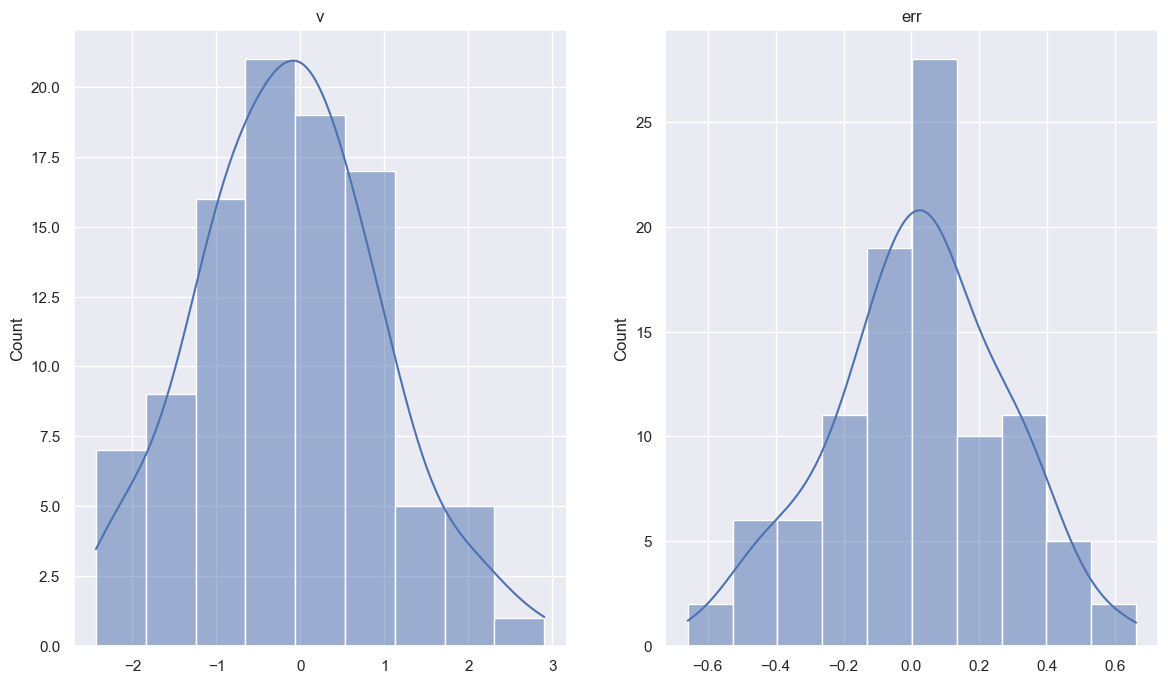

In [2]:
if 'err' in globals():
    fig, axs = plt.subplots(1, 2)
    sns.histplot(v, kde=True, ax=axs[0]).set(title='v')
    sns.histplot(err, kde=True, ax=axs[1]).set(title='err')
else:
    sns.histplot(y, kde=True).set(title='v')

# Classes and Functions

In [3]:
class MLS:
    def __init__(self):
        self.coefs = []
    
    def fit(self, X, y):
        for i in range(0, len(y)):
            try:
                self.coefs.append(np.dot(np.dot(np.linalg.inv(np.dot(X[:i + 1].T, X[:i + 1])),
                                    X[:i + 1].T), y[:i + 1]))
            except np.linalg.LinAlgError:
                self.coefs.append([0 for i in range(X.shape[1])])
        
    def predict(self, X):
        return np.dot(X, self.weights()).flatten()

    def weights(self):
        return np.array(self.coefs[-1])


In [4]:
class RLS:
    def __init__(self, n_features, forgetting_factor=1.0, delta=1.0):
        self.forgetting_factor = forgetting_factor # how much weight we give to older data compared to newer data
        self.delta = delta # regularization
        self.weights = np.zeros((n_features, 1))
        self.covariance_matrix = (1 / delta) * np.eye(n_features)
        self.coefs = []
    
    def fit(self, X, y):
        for i in range(X.shape[0]):
            xi = X[i].reshape(-1, 1)
            yi = y[i]
            prediction = np.dot(xi.T, self.weights)
            error = yi - prediction
            gain = np.dot(self.covariance_matrix, xi) / (self.forgetting_factor + np.dot(np.dot(xi.T, self.covariance_matrix), xi))
            self.weights = self.weights + gain * error
            self.coefs.append(self.weights)
            self.covariance_matrix = (1 / self.forgetting_factor) * (self.covariance_matrix - np.dot(np.dot(gain, xi.T), self.covariance_matrix))
        
    def predict(self, X):
        return np.dot(X, self.weights).flatten()


In [5]:
def metric_S(y_true, y_pred):
    return np.power((y_true-y_pred), 2).sum()

In [6]:
def metric_R_sq(y_true, y_pred):
    return np.var(y_pred)/np.var(y_true)

In [7]:
def metric_IKA(y_true, y_pred, params):
    return len(y_true)*np.log(np.power((y_true-y_pred), 2).sum()) + 2*(params[0]+params[1]+1)

In [8]:
def find_y(v_array):
    y_list = []
    y_list.append(df['a0'][0] + df['v(k)'][0]*v_array[0]) #y_0
    y_list.append(df['a0'][0] + df['a1'][0]*y_list[0] + df['v(k)'][0]*v_array[1] + df['b1'][0]*v_array[0]) #y_1
    y_list.append(df['a0'][0] + df['a1'][0]*y_list[1] + df['a2'][0]*y_list[0] + df['v(k)'][0]*v_array[2] + df['b1'][0]*v_array[1]) #y_2
    y_list.append(df['a0'][0] + df['a1'][0]*y_list[2] + df['a2'][0]*y_list[1] + df['a3'][0]*y_list[0] + df['v(k)'][0]*v_array[3] + df['b1'][0]*v_array[2]) #y_3
    
    for ind, v in enumerate(v_array[3:-1], start=3):
        y = df['a0'][0] + df['a1'][0]*y_list[ind] + df['a2'][0]*y_list[ind-1] + df['a3'][0]*y_list[ind-2] + df['v(k)'][0]*v_array[ind+1] + df['b1'][0]*v_array[ind]
        y_list.append(y)
        
    return np.array(y_list)

# Finding y values

In [9]:
if 'err' in globals():
    y_train = find_y(v) + err
else:
    pass

# Creating pd.DataFrame


In [10]:
y_k_1 = shift(y_train, 1, cval=0)
y_k_2 = shift(y_train, 2, cval=0)
y_k_3 = shift(y_train, 3, cval=0)
v_1 = shift(v, 1, cval=0)
v_2 = shift(v, 2, cval=0)
v_3 = shift(v, 3, cval=0)

In [11]:
X = pd.DataFrame({'a_0': np.ones(100), 'y_k-1': y_k_1,
                    'y_k-2': y_k_2, 'y_k-3': y_k_3, 
                    'v': v, 'v_k-1': v_1, 'v_k-2': v_2, 'v_k-3': v_3})

X

,a_0,y_k-1,y_k-2,y_k-3,v,v_k-1,v_k-2,v_k-3
0,1.0,0.000000,0.000000,0.000000,1.101262,0.000000,0.000000,0.000000
1,1.0,1.320597,0.000000,0.000000,0.338431,1.101262,0.000000,0.000000
2,1.0,2.115697,1.320597,0.000000,-0.539972,0.338431,1.101262,0.000000
3,1.0,0.005463,2.115697,1.320597,-1.260242,-0.539972,0.338431,1.101262
4,1.0,-1.582393,0.005463,2.115697,-1.894621,-1.260242,-0.539972,0.338431
...,...,...,...,...,...,...,...,...
95,1.0,-1.277853,1.815767,0.261892,-0.544869,-1.489277,0.313199,0.910373
96,1.0,-2.272458,-1.277853,1.815767,-0.483312,-0.544869,-1.489277,0.313199
97,1.0,-0.716385,-2.272458,-1.277853,-0.262155,-0.483312,-0.544869,-1.489277
98,1.0,-0.343736,-0.716385,-2.272458,2.284292,-0.262155,-0.483312,-0.544869


# Training models

In [12]:
arma11 = ['a_0', 'y_k-1', 'v', 'v_k-1']
arma12 = ['a_0', 'y_k-1', 'v', 'v_k-1', 'v_k-2']
arma13 = ['a_0', 'y_k-1', 'v', 'v_k-1', 'v_k-2', 'v_k-3']
arma21 = ['a_0', 'y_k-1', 'y_k-2', 'v', 'v_k-1']
arma22 = ['a_0', 'y_k-1', 'y_k-2', 'v', 'v_k-1', 'v_k-2']
arma23 = ['a_0', 'y_k-1', 'y_k-2', 'v', 'v_k-1', 'v_k-2', 'v_k-3']
arma31 = ['a_0', 'y_k-1', 'y_k-2', 'y_k-3', 'v', 'v_k-1']
arma32 = ['a_0', 'y_k-1', 'y_k-2', 'y_k-3', 'v', 'v_k-1', 'v_k-2']
arma33 = ['a_0', 'y_k-1', 'y_k-2', 'y_k-3', 'v', 'v_k-1', 'v_k-2', 'v_k-3']

In [13]:
mls = MLS()

mls.fit(X[arma11], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma11].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma11].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma11].values), [1, 1])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma12], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma12].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma12].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma12].values), [1, 2])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma13], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma13].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma13].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma13].values), [1, 3])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma21], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma21].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma21].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma21].values), [2, 1])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma22], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma22].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma22].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma22].values), [2, 2])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma23], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma23].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma23].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma23].values), [2, 3])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma31], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma31].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma31].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma31].values), [3, 1])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma32], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma32].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma32].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma32].values), [3, 2])}])], axis=0, ignore_index=True) 

mls = MLS()
mls.fit(X[arma33], y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, mls.predict(X[arma33].values)), 'R^2': metric_R_sq(y_train, mls.predict(X[arma33].values)),
                'IKA': metric_IKA(y_train, mls.predict(X[arma33].values), [3, 3])}])], axis=0, ignore_index=True) 

In [14]:
rls = RLS(n_features=len(arma11))

rls.fit(X[arma11].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma11].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma11].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma11].values), [1, 1])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma12))
rls.fit(X[arma12].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma12].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma12].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma12].values), [1, 2])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma13))
rls.fit(X[arma13].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma13].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma13].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma13].values), [1, 3])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma21))
rls.fit(X[arma21].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma21].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma21].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma21].values), [2, 1])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma22))
rls.fit(X[arma22].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma22].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma22].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma22].values), [2, 2])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma23))
rls.fit(X[arma23].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma23].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma23].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma23].values), [2, 3])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma31))
rls.fit(X[arma31].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma31].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma31].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma31].values), [3, 1])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma32))
rls.fit(X[arma32].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma32].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma32].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma32].values), [3, 2])}])], axis=0, ignore_index=True) 

rls = RLS(n_features=len(arma33))
rls.fit(X[arma33].values, y_train)
results = pd.concat([results, pd.DataFrame([{'S': metric_S(y_train, rls.predict(X[arma33].values)), 'R^2': metric_R_sq(y_train, rls.predict(X[arma33].values)),
                'IKA': metric_IKA(y_train, rls.predict(X[arma33].values), [3, 3])}])], axis=0, ignore_index=True) 

# Comparing results

In [15]:
results

,S,R^2,IKA
0,26.731337,0.881961,334.583656
1,26.714075,0.882037,336.519059
2,26.711616,0.882048,338.509851
3,26.229261,0.884178,334.687562
4,26.202225,0.884297,336.584432
5,24.174884,0.893249,330.531425
6,7.603543,0.966425,212.861427
7,7.506175,0.966854,213.572599
8,7.393025,0.967354,214.053699
9,26.763619,0.861310,334.704347


## Plots

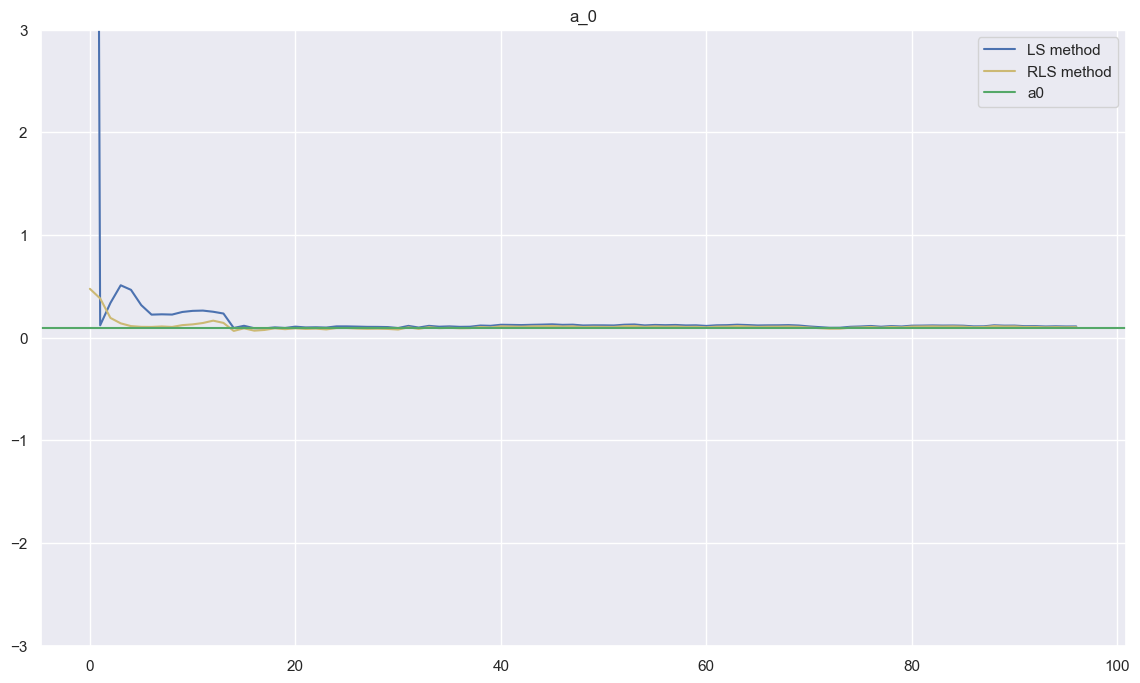

In [16]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 0], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 0], label='RLS method', c='y')
ax.axhline(df['a0'][0], c='g', label='a0')
plt.title('a_0')
ax.legend()

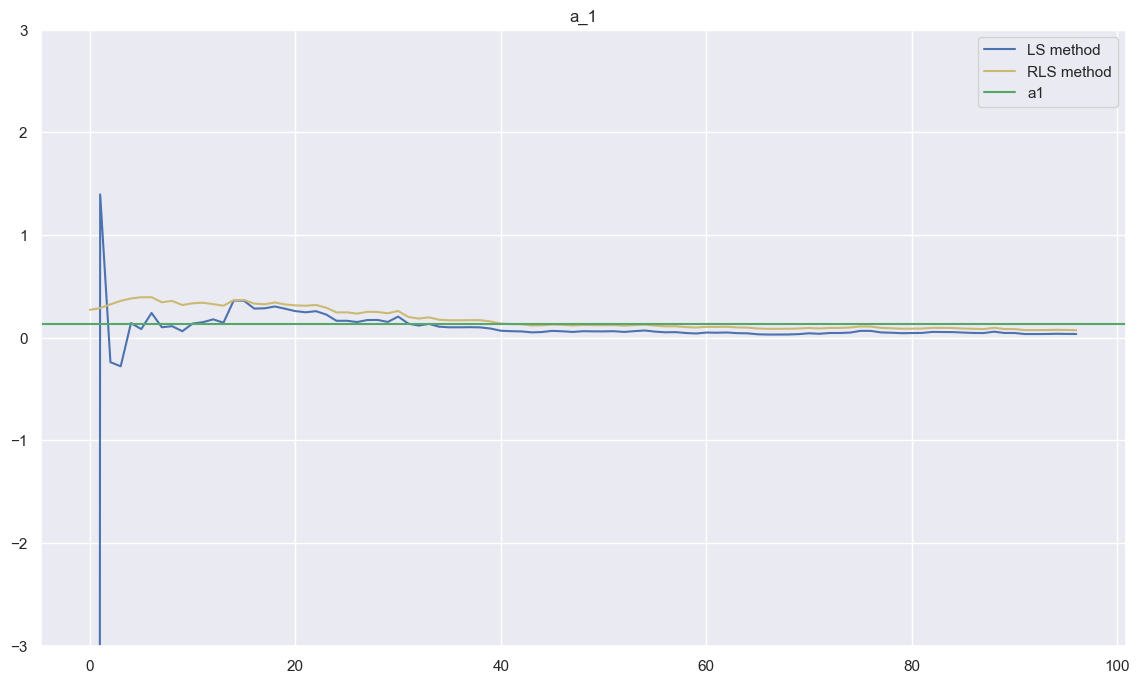

In [17]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 1], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 1], label='RLS method', c='y')
ax.axhline(df['a1'][0], c='g', label='a1')
plt.title('a_1')
ax.legend()

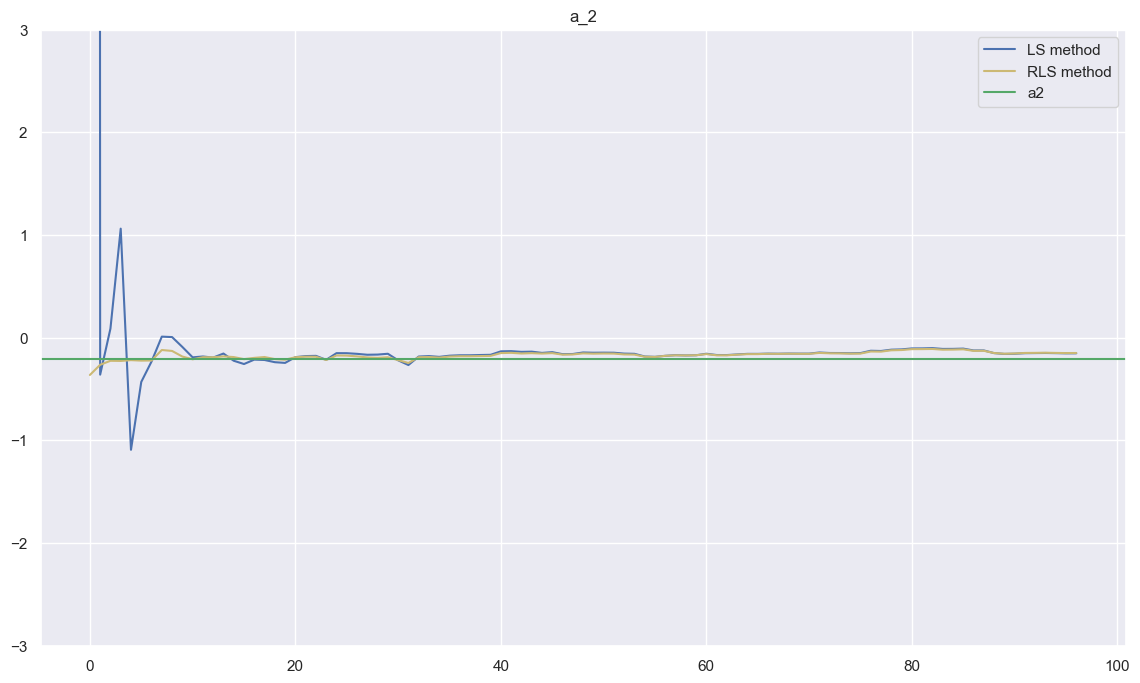

In [18]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 2], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 2], label='RLS method', c='y')
ax.axhline(df['a2'][0], c='g', label='a2')
plt.title('a_2')
ax.legend()

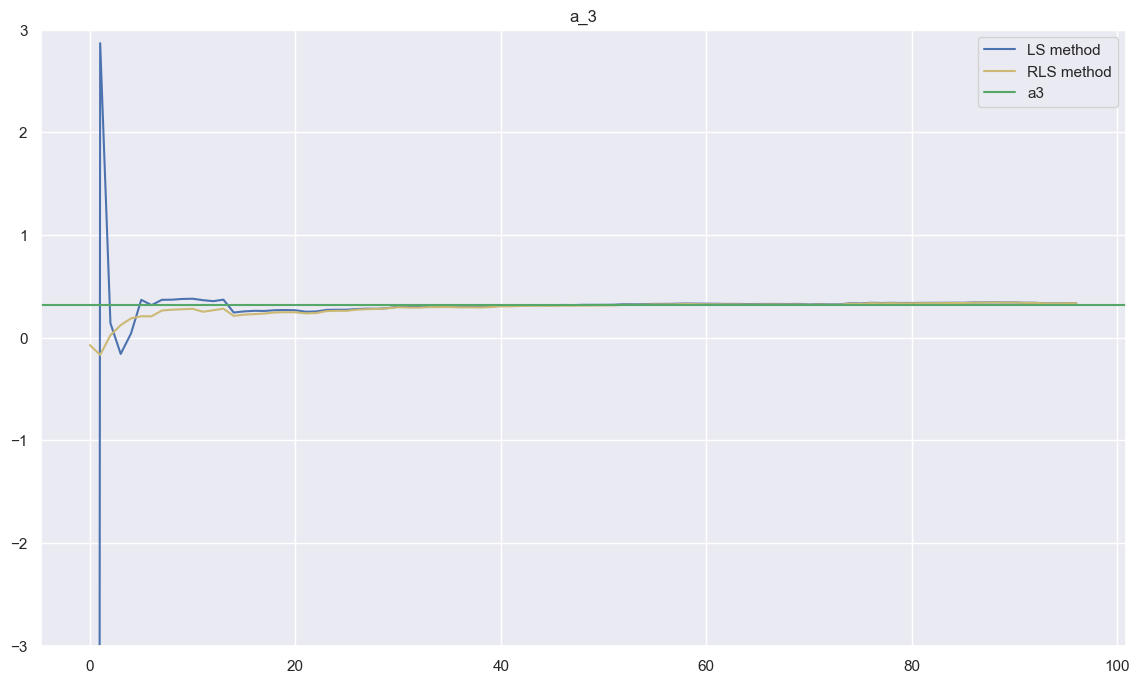

In [19]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 3], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 3], label='RLS method', c='y')
ax.axhline(df['a3'][0], c='g', label='a3')
plt.title('a_3')
ax.legend()

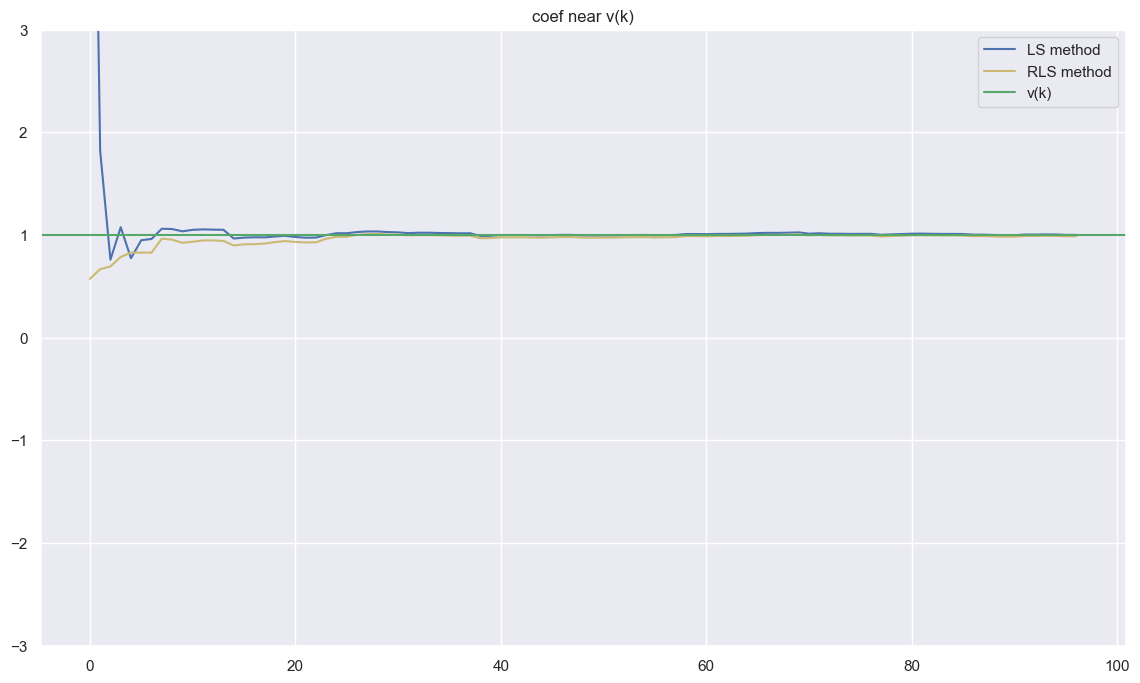

In [20]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 4], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 4], label='RLS method', c='y')
ax.axhline(df['v(k)'][0], c='g', label='v(k)')
plt.title('coef near v(k)')
ax.legend()

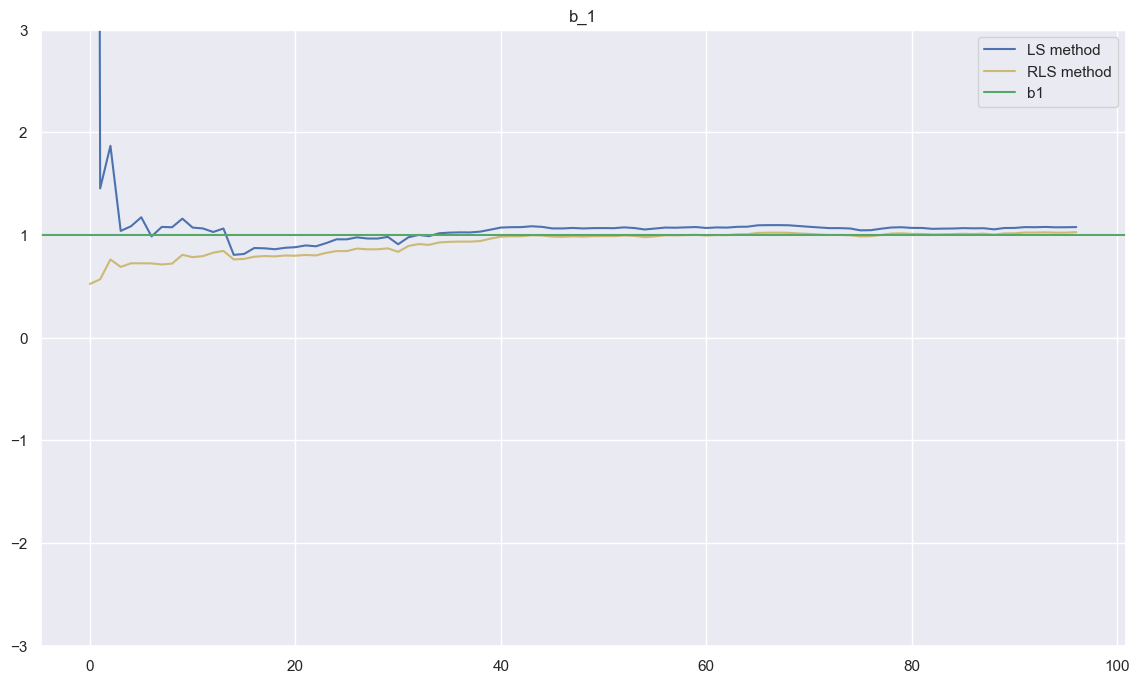

In [21]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 5], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 5], label='RLS method', c='y')
ax.axhline(df['b1'][0], c='g', label='b1')
plt.title('b_1')
ax.legend()

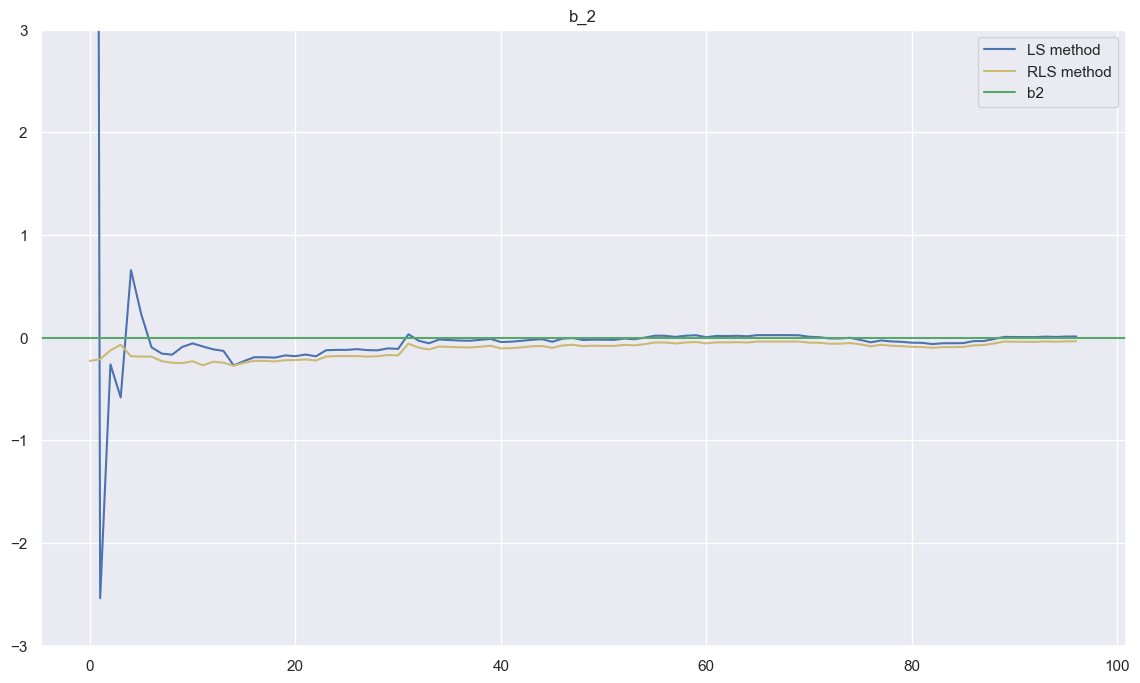

In [22]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 6], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 6], label='RLS method', c='y')
ax.axhline(df['b2'][0], c='g', label='b2')
plt.title('b_2')
ax.legend()

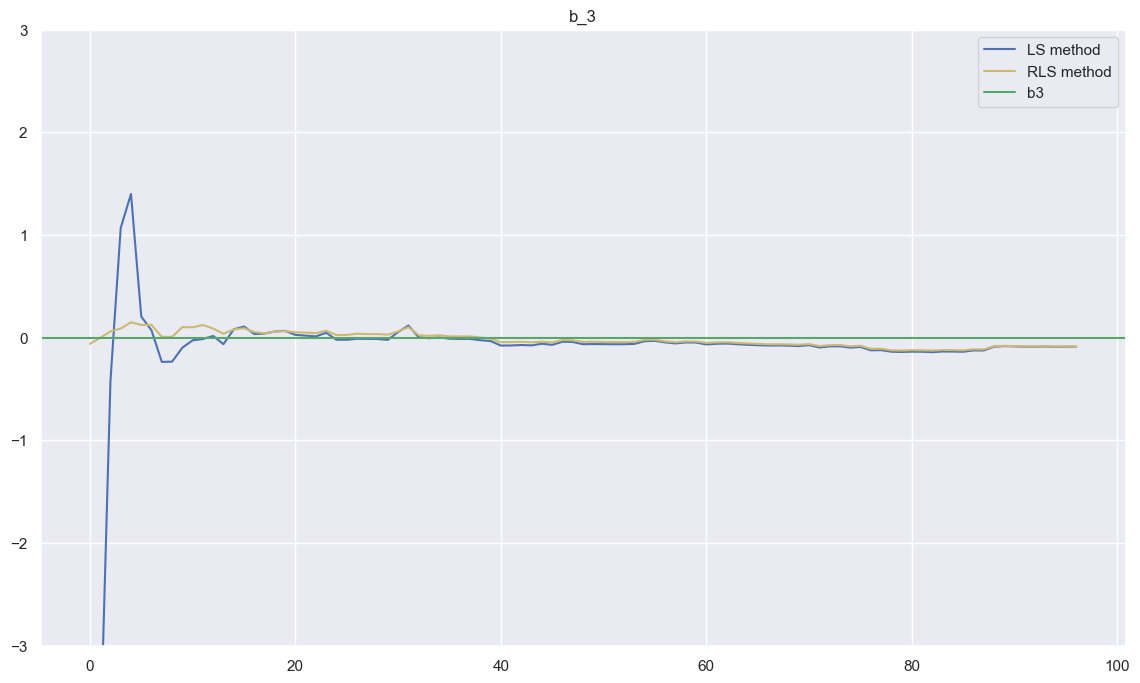

In [23]:
fig, ax = plt.subplots(1, 1)
plt.ylim(-3, 3)

ax.plot(np.array(mls.coefs)[3:, 7], label='LS method', c='b')
ax.plot(np.array(rls.coefs)[3:, 7], label='RLS method', c='y')
ax.axhline(df['b3'][0], c='g', label='b3')
plt.title('b_3')
ax.legend()

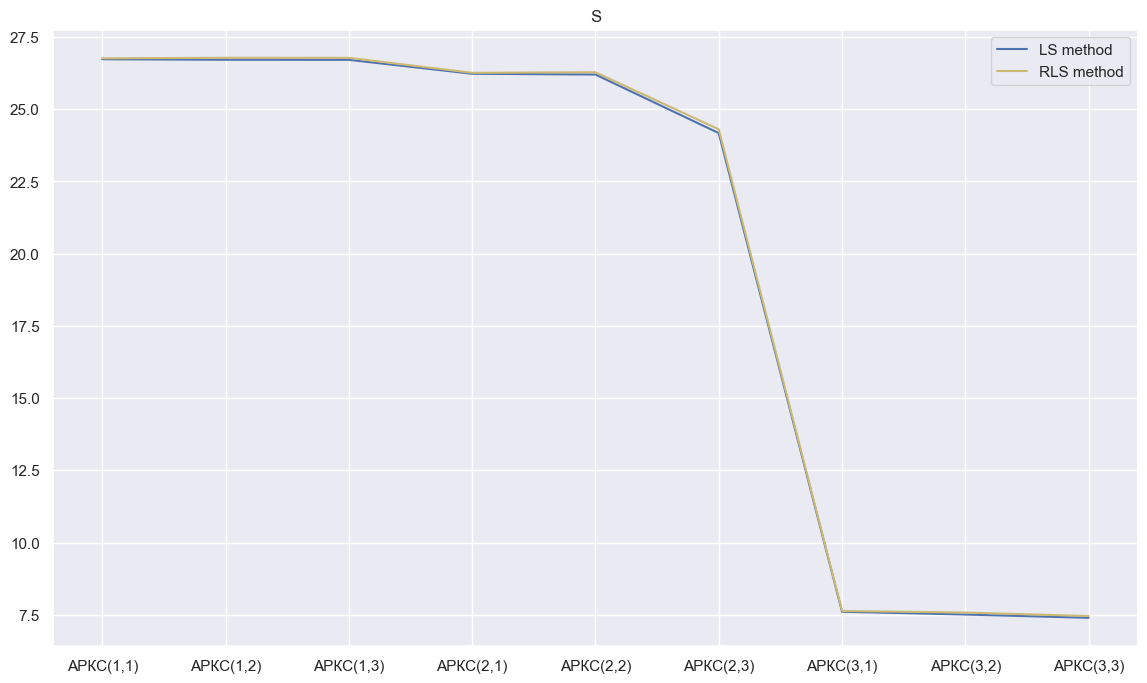

In [24]:
fig, ax = plt.subplots(1, 1)

ax.plot(x_plot, results.loc[0:8]['S'], label='LS method', c='b')
ax.plot(x_plot, results.loc[9:17]['S'], label='RLS method', c='y')
plt.title('S')
ax.legend()

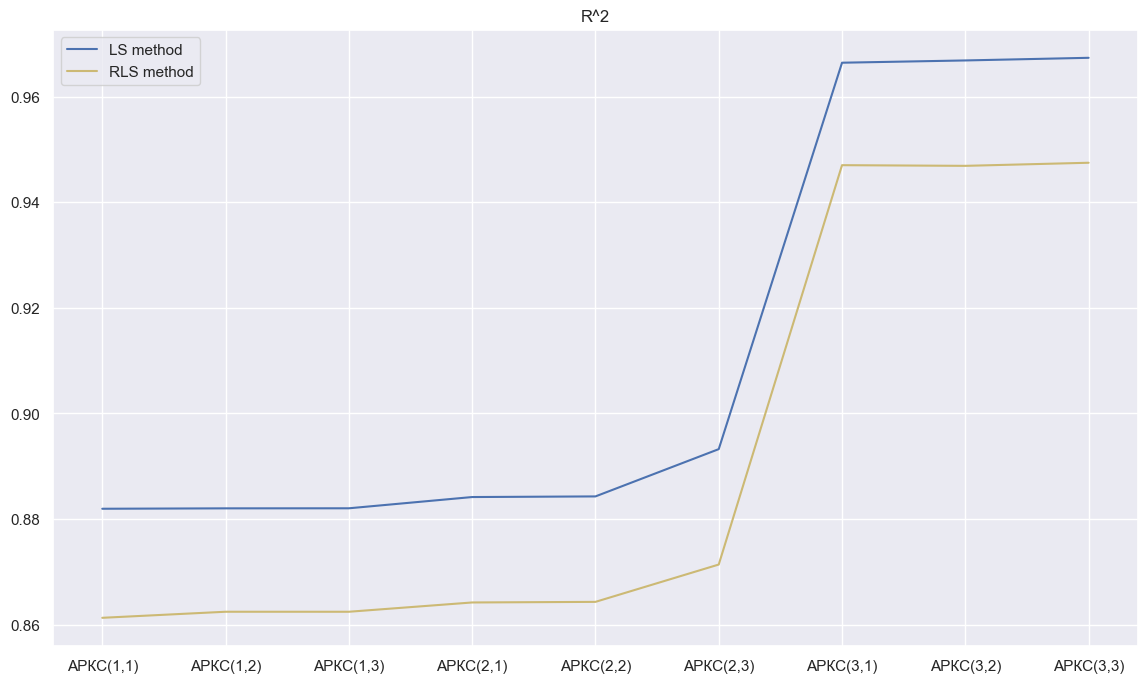

In [25]:
fig, ax = plt.subplots(1, 1)

ax.plot(x_plot, results.loc[0:8]['R^2'], label='LS method', c='b')
ax.plot(x_plot, results.loc[9:17]['R^2'], label='RLS method', c='y')
plt.title('R^2')
ax.legend()

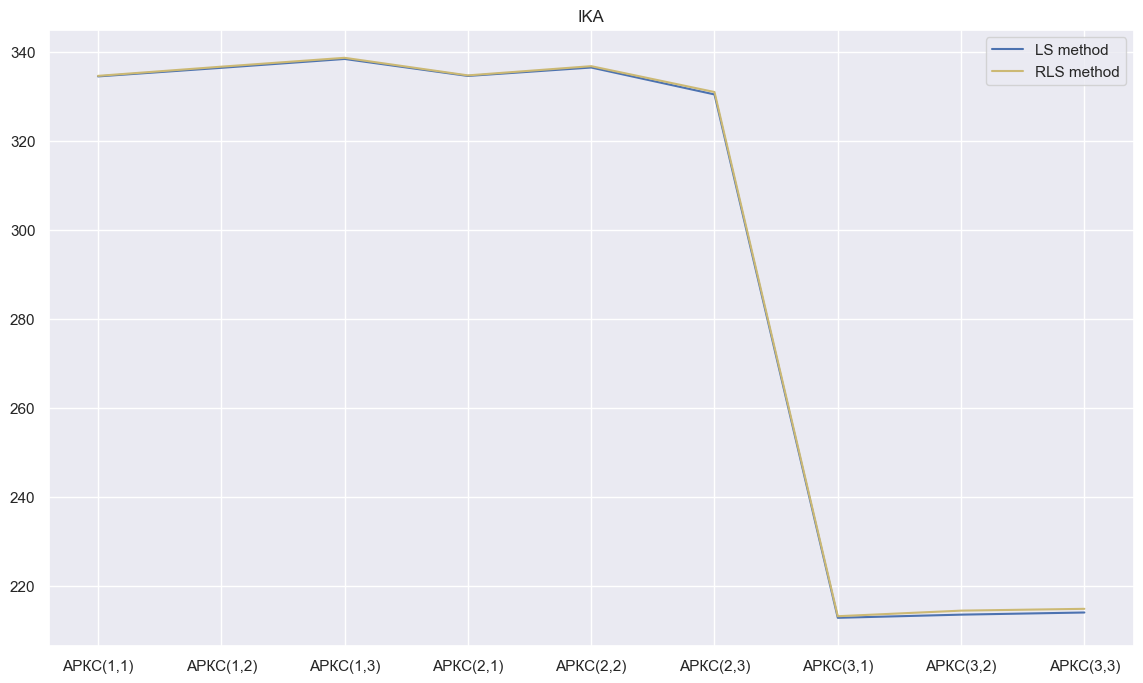

In [26]:
fig, ax = plt.subplots(1, 1)

ax.plot(x_plot, results.loc[0:8]['IKA'], label='LS method', c='b')
ax.plot(x_plot, results.loc[9:17]['IKA'], label='RLS method', c='y')
plt.title('IKA')
ax.legend()